In [93]:
import torch
import datasets
from transformers import Wav2Vec2Processor, Data2VecAudioModel, HubertModel
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.metrics import DistanceMetric

In [94]:
dataset = datasets.load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation")
dataset = dataset.sort("id")
sampling_rate = dataset.features["audio"].sampling_rate
processor = Wav2Vec2Processor.from_pretrained("facebook/data2vec-audio-base-960h")

Found cached dataset librispeech_asr_demo (/home/shreyps/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr_demo/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b)


In [95]:
x, sr = librosa.load((dataset[0]["audio"]['path']))

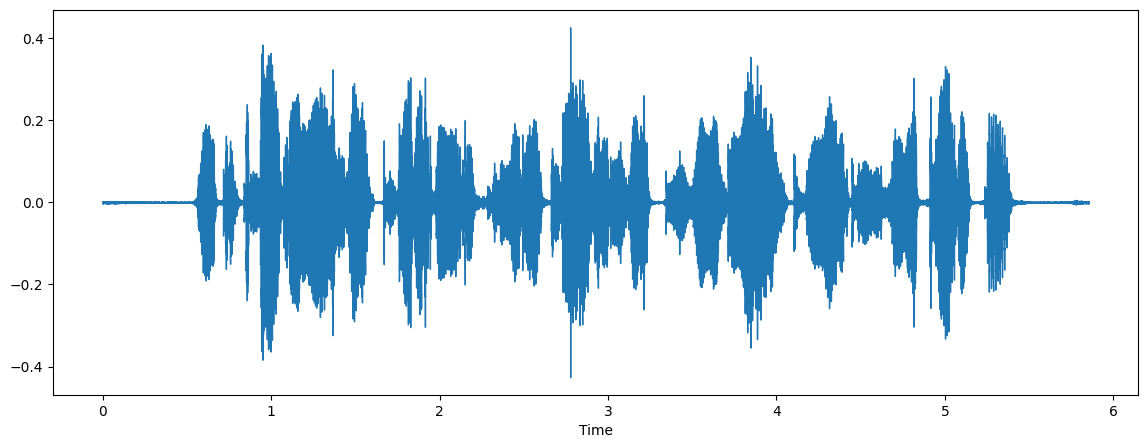

In [96]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

In [97]:
(dataset[0]["audio"]['path'])

'/home/shreyps/.cache/huggingface/datasets/downloads/extracted/260b7d64be845029a2c33c52f1c967472aaa9d8b55c87bad3eed22ac4495db60/dev_clean/1272/128104/1272-128104-0000.flac'

In [7]:
model = Data2VecAudioModel.from_pretrained("m-a-p/music2vec-v1")

In [8]:
inputs = processor(dataset[0]["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

In [9]:
def vectorize_audio(audio_array, sr):
    inputs = processor(audio_array, sampling_rate=sr, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    return outputs.last_hidden_state.squeeze().numpy()

In [10]:
(outputs.hidden_states[-1] == outputs.last_hidden_state).numpy().all()

True

In [11]:
processor(dataset[0]["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt")['input_values'].shape

torch.Size([1, 93680])

In [12]:
dataset[0]["audio"]["array"]

array([0.00238037, 0.0020752 , 0.00198364, ..., 0.00042725, 0.00057983,
       0.0010376 ], dtype=float32)

In [13]:
processor(dataset[0]["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt")['input_values']

tensor([[0.0386, 0.0337, 0.0322,  ..., 0.0070, 0.0095, 0.0169]])

In [14]:
class MusicVectorizer:
    def __init__(self):
        self.processor = Wav2Vec2Processor.from_pretrained("facebook/hubert-large-ls960-ft")
        self.model = HubertModel.from_pretrained("m-a-p/MERT-v0")
    
    def vectorize_audio(self, audio_array, sr):
        inputs = self.processor(audio_array, sampling_rate=sr, return_tensors="pt")
        with torch.no_grad():
            outputs = self.model(**inputs, output_hidden_states=True)
        hidden_states = torch.stack(outputs.hidden_states).squeeze()
        return hidden_states.mean(-2)

In [15]:
mv = MusicVectorizer()

In [16]:
sampling_rate = dataset.features["audio"].sampling_rate
data1 = dataset[0]["audio"]["array"]
data2 = dataset[1]["audio"]["array"]

In [17]:
print(f"original data1 shape: {data1.shape}")
output1 = mv.vectorize_audio(data1, sampling_rate).numpy()
print(f"output1 shape: {output1.shape}")

original data1 shape: (93680,)
output1 shape: (13, 768)


In [18]:
print(f"original data2 shape: {data2.shape}")
output2 = mv.vectorize_audio(data2, sampling_rate).numpy()
print(f"output2 shape: {output2.shape}")

original data2 shape: (77040,)
output2 shape: (13, 768)


In [19]:
for i in range(13):
    cosine_sim = np.dot(output1[i], output2[i])/(np.linalg.norm(output1[i])*np.linalg.norm(output2[i]))
    print(f"cosine similarity between layer {i} is {cosine_sim}")

cosine similarity between layer 0 is 0.96641606092453
cosine similarity between layer 1 is 0.9634666442871094
cosine similarity between layer 2 is 0.9586054086685181
cosine similarity between layer 3 is 0.9623114466667175
cosine similarity between layer 4 is 0.9634968638420105
cosine similarity between layer 5 is 0.970051109790802
cosine similarity between layer 6 is 0.9718080759048462
cosine similarity between layer 7 is 0.9715623259544373
cosine similarity between layer 8 is 0.9714811444282532
cosine similarity between layer 9 is 0.9716527462005615
cosine similarity between layer 10 is 0.9656834602355957
cosine similarity between layer 11 is 0.9389154314994812
cosine similarity between layer 12 is 0.9035314321517944


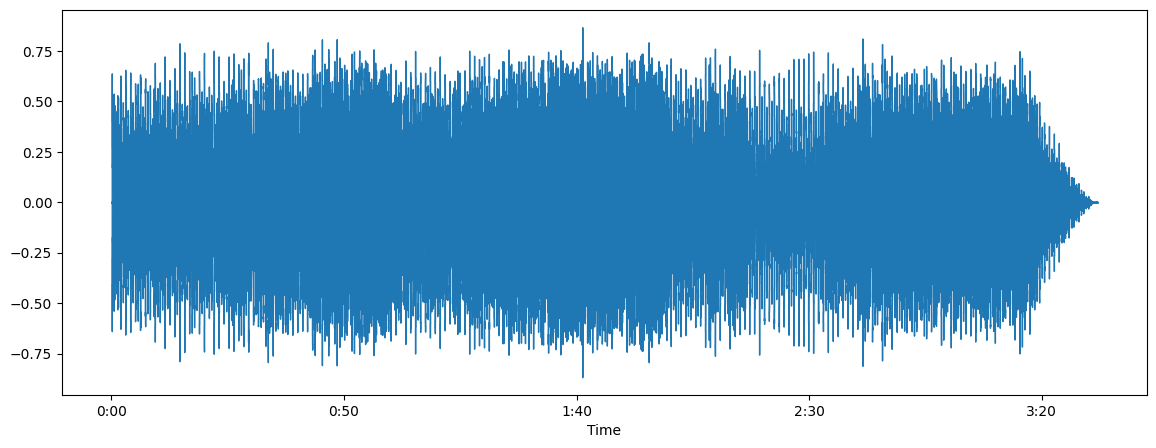

In [21]:
rick, sr = librosa.load("/home/shreyps/eecs448-boombox/data/dQw4w9WgXcQ.mp3", sr=16000)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(rick, sr=sr)

In [28]:
sample_len = 5 # seconds
sample = rick[:sample_len * sr]
test = mv.vectorize_audio(sample, sr)

In [46]:
vectors_np = np.zeros((int(np.ceil(len(rick)/(sample_len*sr))), 13, 768))
vectors = []
start = 0
i = 0
while start < len(rick):
    print(start)
    if sample_len*sr > len(rick):
        sample = rick[start:]
    else:
        sample = rick[start:start + sample_len * sr]
    vector = mv.vectorize_audio(sample, sr)
    vectors.append(vector)
    vectors_np[i] = vector
    start += sample_len * sr
    i += 1

0
80000
160000
240000
320000
400000
480000
560000
640000
720000
800000
880000
960000
1040000
1120000
1200000
1280000
1360000
1440000
1520000
1600000
1680000
1760000
1840000
1920000
2000000
2080000
2160000
2240000
2320000
2400000
2480000
2560000
2640000
2720000
2800000
2880000
2960000
3040000
3120000
3200000
3280000
3360000


In [75]:
layer = 1
filtered = vectors_np[:, layer, :]
dist = DistanceMetric.get_metric('euclidean')
distances = dist.pairwise(filtered)

<Axes: >

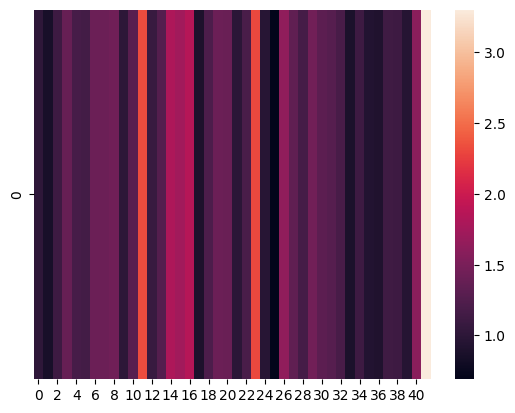

In [76]:
dists = np.diag(distances, k=1)
import seaborn as sns
sns.heatmap(dists.reshape((1, 42)))

In [77]:
sample_len*sr

80000

In [78]:
vectors[0].shape

torch.Size([13, 768])

In [81]:
s1 = np.sum(rick)
s2 = np.sum(output1)
s3 = np.sum(output2)
# get euclidean dist between s1 and s2 
np.linalg.norm(s1 - s2)

57.283966

In [82]:
np.linalg.norm(s1 - s3)

57.51544

In [83]:
np.linalg.norm(s2 - s3)

0.23147774

In [87]:

song_path = "data/classical/Schubert - Marche Militaire Nr 1 (arr P Breiner) - Best-of Classical Music.mp3"
song, sr = librosa.load(song_path, sr=16000)

In [98]:
mv.vectorize_audio(song[0:5*sr], sr)

ValueError: The model corresponding to this feature extractor: Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0,
  "return_attention_mask": true,
  "sampling_rate": 16000
}
 was trained using a sampling rate of 16000. Please make sure that the provided `raw_speech` input was sampled with 16000 and not 22050.